# Multidimensional Kalman Filter without control input

This example locates a vehicle in the xy-plane.
The vehicle has an onboard location sensor that reports x and y coordinates of the system.<br>
Futhermore we assume constannt acceleration dynamics.

In [1]:
# Imports
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt


%matplotlib inline

First we move in a stright line with a constant velocity. After traveling 400 meters the vehicle tunrs right with a turning radius of 300 meters.<br>
During the turning maneuver, the vehicle experiences acceleration due to the circular motion (an angular acceleration).

In [2]:
x = [i for i in range(-400,0)] + [i for i in range(0,300)]
y = [300 for i in range(-400,0)] + [np.sqrt(((300**2)-(i**2))) for i in range(0,300)]
true_trajectorie = [x,y]

Text(0, 0.5, 'meters')

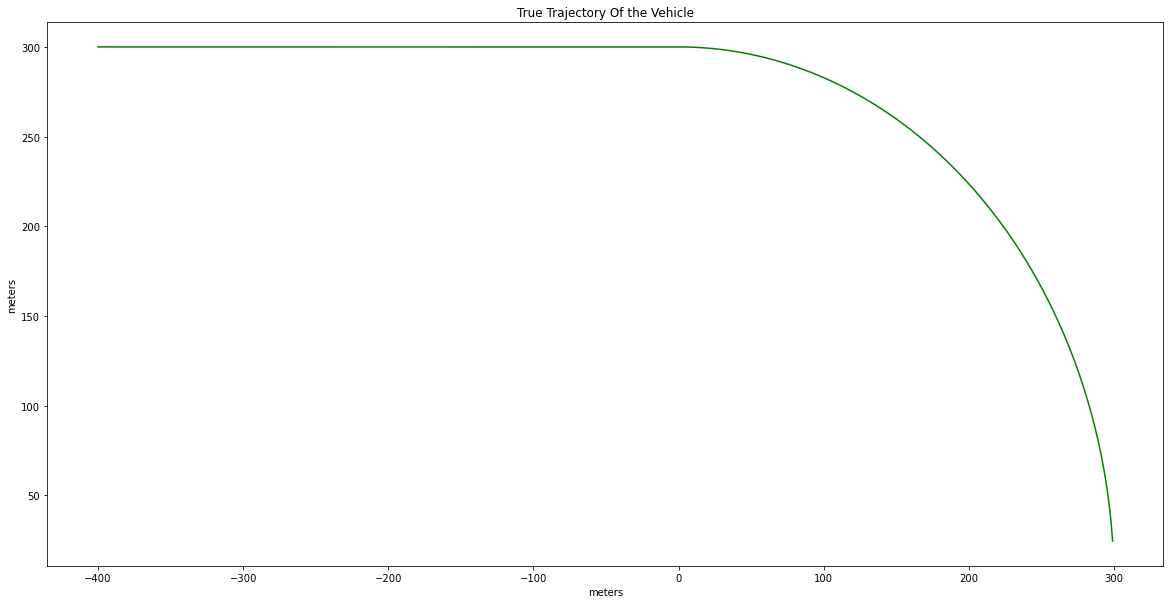

In [3]:
plt.figure(figsize=(20, 10))
plt.plot(x,y,"g")
plt.title("True Trajectory Of the Vehicle")
plt.xlabel("meters")
plt.ylabel("meters")

First we set the values:

Measurement period: $\Delta t = 1s$<br>
Random acceleration standard deviation: $\sigma_{a} = 0.2\frac{m}{s^{2}}$<br>
Measurement error standard deviation: $\sigma_{x_{m}} = \sigma_{y_{m}} = 3m$<br>
State transition matrix $\boldsymbol{F}$:<br>
$\boldsymbol{F} = 
										\left[ \begin{matrix}								
											1 	& \Delta t 		& 0.5\Delta t^{2} 		& 0 				& 0   			& 0\\
											0 	& 1 			& \Delta t 				& 0 		 		& 0 			& 0\\
											0 	& 0 			& 1 					& 0 		 		& 0 			& 0\\
											0 	& 0 			& 0	 					& 1 				& \Delta t 		& 0.5\Delta t^{2}\\
											0 	& 0 			& 0 					& 0 		 		& 1				& \Delta t\\
											0 	& 0 			& 0 					& 0 		 		& 0 			& 1\\
										\end{matrix}
										\right] = 
										\left[ \begin{matrix}								
											1 	& 1 			& 0.5 					& 0 				& 0   			& 0\\
											0 	& 1 			& 1 					& 0 		 		& 0 			& 0\\
											0 	& 0 			& 1 					& 0 		 		& 0 			& 0\\
											0 	& 0 			& 0	 					& 1 				& 1 			& 0.5\\
											0 	& 0 			& 0 					& 0 		 		& 1				& 1\\
											0 	& 0 			& 0 					& 0 		 		& 0 			& 1\\
										\end{matrix}
										\right]$
<br>                                        
Process noise matrix $\boldsymbol{Q}$:<br>
$\boldsymbol{Q} = 
										\left[ \begin{matrix}								
											\frac{\Delta t^{4}}{4} 	& \frac{\Delta t^{3}}{2} 	& \frac{\Delta t^{2}}{2}	& 0 						& 0  						& 0							\\
											\frac{\Delta t^{3}}{2} 	& \Delta t^{2} 				& \Delta t					& 0 						& 0  						& 0							\\
											\frac{\Delta t^{2}}{2} 	& \Delta t					& 1 						& 0 						& 0  						& 0							\\
											0 						& 0 						& 0	 						& \frac{\Delta t^{4}}{4}	& \frac{\Delta t^{3}}{2} 	& \frac{\Delta t^{2}}{2}	\\
											0 						& 0 						& 0	 						& \frac{\Delta t^{3}}{2} 	& \Delta t^{2} 				& \Delta t					\\
											0 						& 0 						& 0	 					 	& \frac{\Delta t^{2}}{2} 	& \Delta t					& 1							\\
										\end{matrix}
										\right]
										\sigma_{a}^{2} = 
										\left[ \begin{matrix}								
											\frac{1}{4} 			& \frac{1}{2} 				& \frac{1}{2}				& 0 						& 0  						& 0							\\
											\frac{1}{2} 			& 1 						& 1							& 0 						& 0  						& 0							\\
											\frac{1}{2} 			& 1							& 1							& 0 						& 0  						& 0							\\
											0 						& 0 						& 0	 						& \frac{1}{4}				& \frac{1}{2} 				& \frac{1}{2}				\\
											0 						& 0 						& 0	 						& \frac{1}{2} 				& 1 						& 1							\\
											0 						& 0 						& 0	 					 	& \frac{1}{2} 				& 1							& 1							\\
										\end{matrix}
										\right]
										0.2^{2}$
<br>                                      
measurement uncertainty $\boldsymbol{R}$:<br> 
$\boldsymbol{R_{n}} = 
										\left[ \begin{matrix}
											\sigma_{x_{m}}^{2} 	&  0 					\\
											0 					&  \sigma_{y_{m}}^{2} 	\\
										\end{matrix}
										\right] = 
										\left[ \begin{matrix}
											9 	&  0 					\\
											0 	&  9 	\\
										\end{matrix}
										\right]$                                       


In [4]:
dt = 1 # second
sigma_a = 0.2
sigma_xm = 3
sigma_ym = 3

F = np.eye(6)
F[0,1] = dt
F[0,2] = 0.5*dt**2

F[1,2] = dt
F[3,4] = dt

F[3,5] = 0.5*dt**2
F[4,5] = dt
  
Q = np.eye(6)
Q[0,0] = (dt**4)/4
Q[0,1] = (dt**3)/2
Q[0,2] = (dt**2)/2

Q[1,0] = (dt**3)/2
Q[1,1] = dt**2
Q[1,0] = dt

Q[2,0] = (dt**2)/2
Q[2,1] = dt
Q[2,0] = 1
          
Q[-1,-1] = 1
Q[-1,-2] = dt
Q[-1,-3] = (dt**2)/2

Q[-2,-1] = dt
Q[-2,-2] = dt**2
Q[-2,-3] = (dt**3)/2

Q[-3,-1] = (dt**2)/2
Q[-3,-2] = (dt**3)/2
Q[-3,-3] = (dt**4)/4

R = np.eye(2)*9

H = np.zeros((2,6))
H[0,0] = 1
H[1,3] = 1

print(f"Measurement period dt: {dt}\n") 
print(f"Random acceleration standard deviation: {sigma_a}\n") 
print(f"Measurement error standard deviation sigma_xm = sigma_ym: {sigma_xm}\n") 
print(f"F Matrix:\n {F}\n")
print(f"R Matrix:\n {R}\n")
print(f"Q Matrix:\n {Q}\n")
print(f"H Matrix:\n {H}\n")

Measurement period dt: 1

Random acceleration standard deviation: 0.2

Measurement error standard deviation sigma_xm = sigma_ym: 3

F Matrix:
 [[1.  1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1. ]]

R Matrix:
 [[9. 0.]
 [0. 9.]]

Q Matrix:
 [[0.25 0.5  0.5  0.   0.   0.  ]
 [1.   1.   0.   0.   0.   0.  ]
 [1.   1.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5  0.5 ]
 [0.   0.   0.   0.5  1.   1.  ]
 [0.   0.   0.   0.5  1.   1.  ]]

H Matrix:
 [[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]



The following noise measurements were made for 35 time steps:

In [5]:
z_x = [-393.66,-375.93,-351.04,-328.96,-299.35,-273.36,-245.89,-222.58,-198.03,-174.17,-146.32,-123.72,-103.47,-78.23,-52.63,-23.34,25.96,49.72,76.94,95.38,119.83,144.01,161.84,180.56,201.42,222.62,239.4,252.51,266.26,271.75,277.4,294.12,301.23,291.8,299.89]
z_y = [300.4,301.78,295.1,305.19,301.06,302.05,300,303.57,296.33,297.65,297.41,299.61,299.6,302.39,295.04,300.09,294.72,298.61,294.64,284.88,272.82,264.93,251.46,241.27,222.98,203.73,184.1,166.12,138.71,119.71,100.41,79.76,50.62,32.99,2.14]
Z = [[z_xi,zyi] for z_xi,zyi in zip(z_x,z_y)]

## Iteration Zero

In [6]:
# Initial System State Vector
X0 = np.zeros(6)
print(X0)

[0. 0. 0. 0. 0. 0.]


In [7]:
# Initial Estimate Uncertainty
P0 = np.eye(6,6)*500
print(P0)

[[500.   0.   0.   0.   0.   0.]
 [  0. 500.   0.   0.   0.   0.]
 [  0.   0. 500.   0.   0.   0.]
 [  0.   0.   0. 500.   0.   0.]
 [  0.   0.   0.   0. 500.   0.]
 [  0.   0.   0.   0.   0. 500.]]


In [8]:
# Prediction
Pred_X1 = np.dot(F,X0)
Pred_P1 = np.dot(np.dot(F,P0),F.T) + Q

In [9]:
print(f"{Pred_X1}\n")
print(f"{Pred_P1}\n")

[0. 0. 0. 0. 0. 0.]

[[1125.25  750.5   250.5     0.      0.      0.  ]
 [ 751.   1001.    500.      0.      0.      0.  ]
 [ 251.    501.    501.      0.      0.      0.  ]
 [   0.      0.      0.   1125.25  750.5   250.5 ]
 [   0.      0.      0.    750.5  1001.    501.  ]
 [   0.      0.      0.    250.5   501.    501.  ]]



## Iteration One
### Measure

In [10]:
z1 = Z[0]
print(z1)

[-393.66, 300.4]


### Update

In [11]:
K1 = np.dot(np.dot(Pred_P1,H.T),np.linalg.inv(np.dot(np.dot(H,Pred_P1),H.T) + R))
print(K1)

[[0.99206524 0.        ]
 [0.66211153 0.        ]
 [0.2212916  0.        ]
 [0.         0.99206524]
 [0.         0.66167071]
 [0.         0.22085078]]


In [12]:
Estimate_X1 = Pred_X1 + np.dot(K1,(z1- np.dot(H,Pred_X1)))
print(Estimate_X1)

[-390.53640291 -260.64682389  -87.11365219  298.0163985   198.76588054
   66.34357505]


In [13]:
Estimate_P1 = np.dot(np.dot((np.eye(6) - np.dot(K1,H)),Pred_P1),(np.eye(6) - np.dot(K1,H)).T) + np.dot(np.dot(K1,R),K1.T)
print(Estimate_P1)

[[  8.92858717   5.95503637   1.98765704   0.           0.
    0.        ]
 [  5.95900375 504.08529866 334.14106238   0.           0.
    0.        ]
 [  1.99162442 334.92065241 445.5664536    0.           0.
    0.        ]
 [  0.           0.           0.           8.92858717   5.95503637
    1.98765704]
 [  0.           0.           0.           5.95503637 504.41613401
  335.25148777]
 [  0.           0.           0.           1.98765704 335.25148777
  445.67687899]]


### Prediction

In [14]:
Pred_X2 = np.dot(F,Estimate_X1)
Pred_P2 = np.dot(np.dot(F,Estimate_P1),F.T) + Q

print(f"{Pred_X2}\n")
print(Pred_P2)

[-694.7400529  -347.76047609  -87.11365219  529.95406656  265.10945559
   66.34357505]

[[ 973.09003747 1236.91260745  559.41194622    0.            0.
     0.        ]
 [1237.81033723 1619.71346705  779.70751598    0.            0.
     0.        ]
 [ 560.69550364  781.48710602  446.5664536     0.            0.
     0.        ]
 [   0.            0.            0.          974.16315847 1238.57449857
   560.57758431]
 [   0.            0.            0.         1238.57449857 1621.59598854
   781.92836676]
 [   0.            0.            0.          560.57758431  781.92836676
   446.67687899]]


## Iteration Two
### Measure

In [15]:
z2 = Z[1]

### Update

In [16]:
K2 = np.dot(np.dot(Pred_P2,H.T),np.linalg.inv(np.dot(np.dot(H,Pred_P2),H.T) + R))
print(K2)

[[0.99083587 0.        ]
 [1.26038376 0.        ]
 [0.57092067 0.        ]
 [0.         0.99084587]
 [0.         1.2597853 ]
 [0.         0.57017757]]


In [17]:
Estimate_X2 = Pred_X2 + np.dot(K2,(z2- np.dot(H,Pred_X2)))
print(Estimate_X1)

[-390.53640291 -260.64682389  -87.11365219  298.0163985   198.76588054
   66.34357505]


In [18]:
Estimate_X2 = Pred_X2 + np.dot(K2,(z2- np.dot(H,Pred_X2)))
Estimate_P2 = np.dot(np.dot((np.eye(6) - np.dot(K2,H)),Pred_P2),(np.eye(6) - np.dot(K2,H)).T) + np.dot(np.dot(K2,R),K2.T)
print(Estimate_P2)

[[  8.91752284  11.33522696   5.12652336   0.           0.
    0.        ]
 [ 11.34345387  60.72890012  74.63378202   0.           0.
    0.        ]
 [  5.13828604  75.30812962 127.18660964   0.           0.
    0.        ]
 [  0.           0.           0.           8.91761286  11.33806774
    5.13159816]
 [  0.           0.           0.          11.33806774  61.25803723
   75.72096425]
 [  0.           0.           0.           5.13159816  75.72096425
  127.04811207]]


## Predict

In [19]:
Pred_X3 = np.dot(F,Estimate_X2)
Pred_P3 = np.dot(np.dot(F,Estimate_P2),F.T) + Q

print(f"{Pred_X3}\n")
print(Pred_P3)

[-277.33827975  148.96413541   94.90159728  249.64977373  -86.09704086
  -63.75616062]

[[204.47511672 253.57180209 143.8536102    0.           0.
    0.        ]
 [254.42896549 338.85742141 201.82039166   0.           0.
    0.        ]
 [145.03972048 203.49473926 128.18660964   0.           0.
    0.        ]
 [  0.           0.           0.         205.71637599 255.33320554
  144.87661845]
 [  0.           0.           0.         255.33320554 340.7480778
  203.76907632]
 [  0.           0.           0.         144.87661845 203.76907632
  128.04811207]]


## Iteration ...

The example will no be implmented into functions and classes as seen in the other examples.
For better comparison, most values will be set manually to fulfill the output of the example above.

In [35]:
class Filter:
    def __init__(self, measurement_uncertainty=3):

        self.dt = 1 # second
        self.sigma_a = 0.2
        self.sigma_xm = 3
        self.sigma_ym = 3

        self.F = np.eye(6)
        self.init_F()
        
        self.Q = np.eye(6)
        self.init_Q()
        
        self.R = np.eye(2)*measurement_uncertainty**2
        
        self.H = np.zeros((2,6))
        self.init_H()
        
        self.Z = None
        self.init_Z()
        
        self.X_True = None
        self.init_X_True()
        
        self.K = None
        self.Ks = []
        
        self.X_Pred = None
        self.Xs_Pred = []
        
        self.P_Pred = None
        
        self.X_Estimate = np.zeros(6)
        self.Xs_Estimate = []
        
        self.P_Estimate =  np.eye(6)*500
        
        self.run_flag = False
        
        
    def run(self):
        
        self.run_flag = True
        
        for i in range(len(self.Z)):
        
            self.X_Pred = np.dot(self.F,self.X_Estimate)
            self.P_Pred = np.dot(np.dot(self.F,self.P_Estimate),self.F.T) + self.Q
        
            z = self.Z[i]
            
            self.K = np.dot(np.dot(self.P_Pred,self.H.T),np.linalg.inv(np.dot(np.dot(self.H,self.P_Pred),self.H.T) + self.R))
            
            self.X_Estimate = self.X_Pred + np.dot(self.K,(z - np.dot(self.H,self.X_Pred)))
            self.P_Estimate = np.dot(np.dot((np.eye(6) - np.dot(self.K,self.H)),self.P_Pred),(np.eye(6) - np.dot(self.K,self.H)).T) + np.dot(np.dot(self.K,self.R),self.K.T)
            
            self.Xs_Estimate.append(self.X_Estimate)
            
        
    def init_X_True(self):
        x = [i for i in range(-400,0)] + [i for i in range(0,300)]
        y = [300 for i in range(-400,0)] + [np.sqrt(((300**2)-(i**2))) for i in range(0,300)]
        self.X_True = [x,y]
        
        
    def init_Z(self):
        z_x = [-393.66,-375.93,-351.04,-328.96,-299.35,-273.36,-245.89,-222.58,-198.03,
               -174.17,-146.32,-123.72,-103.47,-78.23,-52.63,-23.34,25.96,49.72,76.94,95.38,
               119.83,144.01,161.84,180.56,201.42,222.62,239.4,252.51,266.26,271.75,
               277.4,294.12,301.23,291.8,299.89]
        
        z_y = [300.4,301.78,295.1,305.19,301.06,302.05,300,303.57,296.33,297.65,297.41,
               299.61,299.6,302.39,295.04,300.09,294.72,298.61,294.64,284.88,272.82,264.93,
               251.46,241.27,222.98,203.73,184.1,166.12,138.71,119.71,100.41,79.76,50.62,
               32.99,2.14]
        
        self.Z = [[z_xi,zyi] for z_xi,zyi in zip(z_x,z_y)]

    def init_H(self):
        self.H[0,0] = 1
        self.H[1,3] = 1
        
    def init_F(self):   
        
        self.F[0,1] = self.dt
        self.F[0,2] = 0.5*self.dt**2

        self.F[1,2] = self.dt
        self.F[3,4] = self.dt

        self.F[3,5] = 0.5*self.dt**2
        self.F[4,5] = self.dt
  
    def init_Q(self):
  
        self.Q[0,0] = (self.dt**4)/4
        self.Q[0,1] = (self.dt**3)/2
        self.Q[0,2] = (self.dt**2)/2

        self.Q[1,0] = (self.dt**3)/2
        self.Q[1,1] = self.dt**2
        self.Q[1,0] = self.dt

        self.Q[2,0] = (self.dt**2)/2
        self.Q[2,1] = self.dt
        Q[2,0] = 1

        self.Q[-1,-1] = 1
        self.Q[-1,-2] = self.dt
        self.Q[-1,-3] = (self.dt**2)/2

        self.Q[-2,-1] = self.dt
        self.Q[-2,-2] = self.dt**2
        self.Q[-2,-3] = (dt**3)/2

        self.Q[-3,-1] = (self.dt**2)/2
        self.Q[-3,-2] = (self.dt**3)/2
        self.Q[-3,-3] = (self.dt**4)/4

        
    def print_initial_values(self):
        print(f"Initial Values:")
        print(f"----------------------------------------------")
        print(f"Measurement period dt: {self.dt}\n") 
        print(f"Random acceleration standard deviation: {self.sigma_a}\n") 
        print(f"Measurement error standard deviation sigma_xm = sigma_ym: {self.sigma_xm}\n") 
        print(f"Recorded XY Measurements:\n {self.Z}\n")
        print(f"F Matrix:\n {self.F}\n")
        print(f"R Matrix:\n {self.R}\n")
        print(f"Q Matrix:\n {self.Q}\n")
        print(f"H Matrix:\n {self.H}\n")
        print(f"----------------------------------------------")
        
    def print_results(self):
        if not self.run_flag:
            print("Execute the function run() first.")
            return
        
        print(f"Results (Last Iteration):")
        print(f"----------------------------------------------")
        print(f"Kalman Gain:\n{self.K.round(2)}\n")
        print(f"Estimate X:\n{self.X_Estimate.round(2)}\n")
        print(f"Estimate P:\n {self.P_Estimate.round(2)}\n")
        print(f"----------------------------------------------")
        
    def plot_results(self):
        
        fig=plt.figure(figsize=(20,10))
        ax=fig.add_subplot(111)
        ax2=fig.add_subplot(111, frame_on=False)
        ax3=fig.add_subplot(111,frame_on=False)
        ax.set_title("Multidimensional Kalman Filter")
        fig.supxlabel('meters')
        fig.supylabel('meters')
        
        ax.plot(self.X_True[0],self.X_True[1],"g")

        ax2.plot(np.array(self.Z)[:,0],np.array(self.Z)[:,1],"b-*")
        ax2.set_xticks([])
        ax2.set_yticks([])
        
        ax3.plot(np.array(self.Xs_Estimate)[:,0],np.array(self.Xs_Estimate)[:,3],"r-+")
        ax3.set_xticks([])
        ax3.set_yticks([])
        
        ax.legend(["True Values"],loc="lower left", bbox_to_anchor=(0.1,0.1))
        ax2.legend(["Measurements"],loc="lower left", bbox_to_anchor=(0.1,0.14))
        ax3.legend(["Estimation"],loc="lower left", bbox_to_anchor=(0.1,0.18))

        

## Results

In [45]:
f = Filter()
f.print_initial_values()
f.run()

Initial Values:
----------------------------------------------
Measurement period dt: 1

Random acceleration standard deviation: 0.2

Measurement error standard deviation sigma_xm = sigma_ym: 3

Recorded XY Measurements:
 [[-393.66, 300.4], [-375.93, 301.78], [-351.04, 295.1], [-328.96, 305.19], [-299.35, 301.06], [-273.36, 302.05], [-245.89, 300], [-222.58, 303.57], [-198.03, 296.33], [-174.17, 297.65], [-146.32, 297.41], [-123.72, 299.61], [-103.47, 299.6], [-78.23, 302.39], [-52.63, 295.04], [-23.34, 300.09], [25.96, 294.72], [49.72, 298.61], [76.94, 294.64], [95.38, 284.88], [119.83, 272.82], [144.01, 264.93], [161.84, 251.46], [180.56, 241.27], [201.42, 222.98], [222.62, 203.73], [239.4, 184.1], [252.51, 166.12], [266.26, 138.71], [271.75, 119.71], [277.4, 100.41], [294.12, 79.76], [301.23, 50.62], [291.8, 32.99], [299.89, 2.14]]

F Matrix:
 [[1.  1.  0.5 0.  0.  0. ]
 [0.  1.  1.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  1.  1.  0.5]
 [0.  0.  0.  0.  1.  1. ]
 [0.  

In [46]:
f.print_results()

Results (Last Iteration):
----------------------------------------------
Kalman Gain:
[[0.75 0.  ]
 [0.55 0.  ]
 [0.21 0.  ]
 [0.   0.75]
 [0.   0.5 ]
 [0.   0.17]]

Estimate X:
[298.49  -0.61  -2.23   3.89 -26.2   -1.29]

Estimate P:
 [[6.76 4.19 1.17 0.   0.   0.  ]
 [4.98 5.97 1.73 0.   0.   0.  ]
 [1.92 4.01 2.59 0.   0.   0.  ]
 [0.   0.   0.   6.75 4.5  1.5 ]
 [0.   0.   0.   4.5  6.   3.  ]
 [0.   0.   0.   1.5  3.   2.  ]]

----------------------------------------------


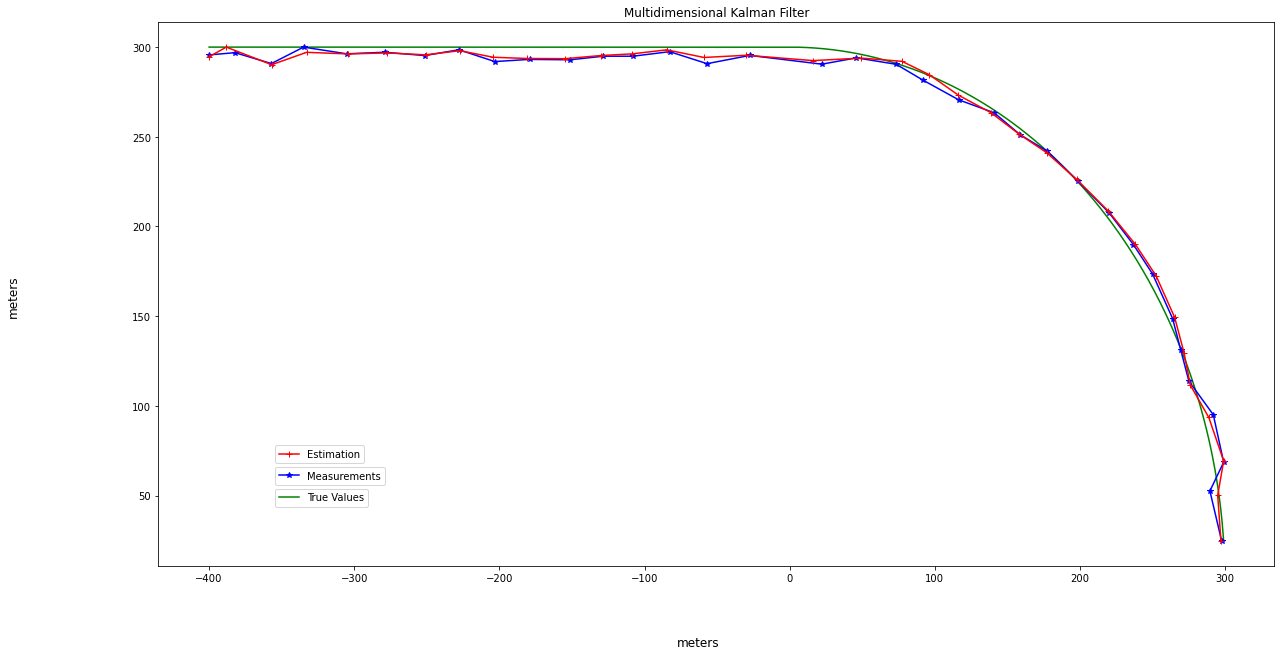

In [47]:
f.plot_results()